In [35]:
import pandas as pd
import xgboost
from xgboost import plot_tree
import lightgbm
import catboost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import jiho_module as jm
import joblib

- 파이프라인 셋 / 업데이트
- 파라미터 셋 / 업데이트

In [2]:
class Test:
    def __init__(self):
        params_rf ={
            'n_estimators' : [100],
            'max_depth':[2,8,10,30],
            'min_samples_leaf':[2,8,12,20],
            'min_samples_split':[8,16,20]
        }
        params_xgb = {
            "max_depth": [10,30,50],
            "min_child_weight" : [1,3,6,10],
            "n_estimators": [200,300,500,1000],
            'learning_rate': [0.01]
        }
        params_lgb = {
            "learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5],
            "max_depth" : [25, 50, 75],
            "num_leaves" : [100,300,500,900,1200],
            "n_estimators" : [100, 200, 300,500,800,1000],
            "learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5]
        }
        params_cat = {
            "learning_rate" : '',
            "random_strength" : '',
            "L2_regulariser " : ''
        }



## Training & Test no.1

- Data : 
    train_df_merged, members_df_v3, transaction_df_merged, user_logs_df_merged </br>
    inner join on msno </br>
    fillna(-1) </br>
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) </br></br>

- Features : </br>
    'is_churn' : Target column</br>
    'city' : one hot encoding</br>
    'bd' : </br>
    'gender' : one hot encoding</br>
    'registered_via' : one hot encoding</br>
    'registration_init_time' : int (not date type)</br>
    'count' : count of group by of user_log</br>
    'total_periods' : jiho_module.active_day_per_total(transaction_df)</br>
    'active_per_periods' : count/total_periods</br></br>

- Model : XGBoost</br></br>

- params : </br>
    "max_depth": [6,10,30,50],</br>
    "min_child_weight" : [1,3,6,10],</br>
    "n_estimators": [10,50,100,300],</br>
    "learning_rate': [0.01]</br>

In [2]:
df = pd.read_csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/df_target3.csv')

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

y = df['is_churn']
X = df.iloc[:,1:]

X = X.fillna(-1)
y = y.fillna(-1)

X = pd.get_dummies(X, columns=['city', 'gender', 'registered_via'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [4]:
df.shape

(955126, 9)

In [5]:
xgb = xgboost.XGBClassifier()

params_xgb = {
            "max_depth": [6,10,30,50],
            "min_child_weight" : [1,3,6,10],
            "n_estimators": [10,50,100,300],
            'learning_rate': [0.01]
        }

gs = GridSearchCV(estimator=xgb, param_grid=params_xgb, scoring='roc_auc', n_jobs=-1)

In [9]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [6, 10, 30, 50],
                         'min_child_weight': [1, 3, 6, 10],
                         'n_estimators': [10, 50, 100, 300]},
             scoring='roc_auc')

In [48]:
print('best parameters : ', gs.best_params_)
print('best score : ', gs.best_score_)
em = gs.best_estimator_
pred = em.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))
print("precision:", precision_score(y_test, pred))
print("recall:", recall_score(y_test, pred))
print("f1 score:", f1_score(y_test, pred))
print(confusion_matrix(y_test, pred))


best parameters :  {'learning_rate': 0.01, 'max_depth': 30, 'min_child_weight': 10, 'n_estimators': 300}
best score :  0.9017702748697204
accuracy: 0.8994063635316658
precision: 0.7326530612244898
recall: 0.34899546338302007
f1 score: 0.47278314310798947
[[163194   3144]
 [ 16072   8616]]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

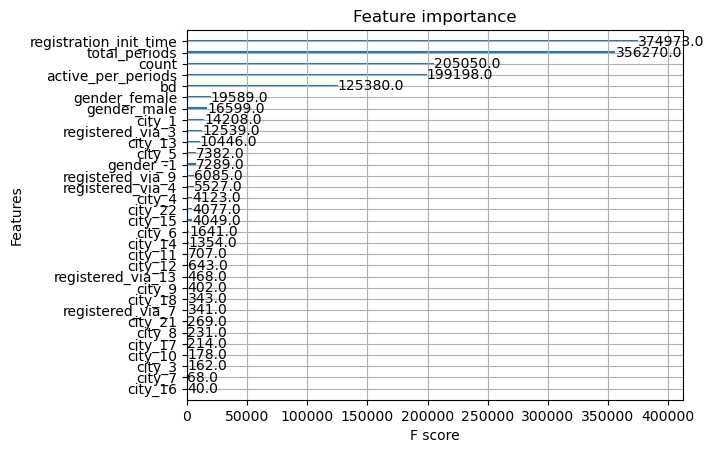

In [38]:
xgboost.plot_importance(em)

## Training & Test no.2

>* almost same with Training & Test no.1
>* reset hyperparameters
>* use RandomUnderSampler

- Data : 
    train_df_merged, members_df_v3, transaction_df_merged, user_logs_df_merged </br>
    inner join on msno </br>
    fillna(-1) </br>
    X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size=0.2, stratify=y_under) </br></br>

- Features : </br>
    'is_churn' : Target column</br>
    'city' : one hot encoding</br>
    'bd' : </br>
    'gender' : one hot encoding</br>
    'registered_via' : one hot encoding</br>
    'registration_init_time' : int (not date type)</br>
    'count' : count of group by of user_log</br>
    'total_periods' : jiho_module.active_day_per_total(transaction_df)</br>
    'active_per_periods' : count/total_periods</br></br>

- Model : XGBoost</br></br>

- params : </br>
    "max_depth": [20,30,40],</br>
    "min_child_weight" : [9,10,15],</br>
    "n_estimators": [300,500,1000],</br>
    'learning_rate': [0.01]</br>

In [6]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)

In [7]:
print(len(X_under), len(y_under))

246878 246878


In [17]:
y_under.sum()

123439

In [8]:
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size=0.2, stratify=y_under)

In [9]:
xgb_test2 = xgboost.XGBClassifier()

params_xgb_test2 = {
            "max_depth": [20,30,40],
            "min_child_weight" : [9,10,15],
            "n_estimators": [300,500,1000],
            'learning_rate': [0.01]
        }

gs_test2 = GridSearchCV(estimator=xgb_test2, param_grid=params_xgb_test2, scoring='roc_auc', n_jobs=-1)

In [10]:
gs_test2.fit(X_under_train, y_under_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [20, 30, 40],
                         'min_child_weight': [9, 10, 15],
                         'n_estimators': [300, 500, 1000]},
             scoring='roc_auc')

In [11]:
print('best parameters : ', gs_test2.best_params_)
print('best score : ', gs_test2.best_score_)
best_test2 = gs_test2.best_estimator_
pred_test2 = gs_test2.predict(X_under_test)

print("accuracy:", accuracy_score(y_under_test, pred_test2))
print("precision:", precision_score(y_under_test, pred_test2))
print("recall:", recall_score(y_under_test, pred_test2))
print("f1 score:", f1_score(y_under_test, pred_test2))
print(confusion_matrix(y_under_test, pred_test2))


best parameters :  {'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 9, 'n_estimators': 1000}
best score :  0.8987286900301447
accuracy: 0.8195682112767336
precision: 0.7855514133700098
recall: 0.8791315618924174
f1 score: 0.8297111837452453
[[18763  5925]
 [ 2984 21704]]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

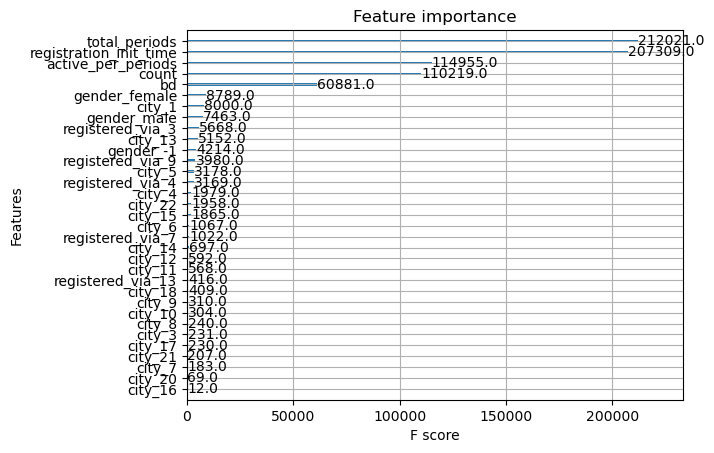

In [18]:
xgboost.plot_importance(best_test2)

In [36]:
joblib.dump(best_test2, open('xgb_model_test2.model', 'wb'))

## training & test 3

In [21]:
xgb_test3 = xgboost.XGBClassifier(learning_rate=0.01, max_depth=20, min_child_weight=9, n_estimators=1000)

In [24]:
X_test3 = X[['count', 'total_periods', 'active_per_periods']]
y_test3 = y

In [25]:
X_test3_under, y_test3_under = undersample.fit_resample(X_test3, y_test3)

In [26]:
X_test3_under_train, X_test3_under_test, y_test3_under_train, y_test3_under_test = train_test_split(X_test3_under, y_test3_under, test_size=0.2, stratify=y_under)

In [28]:
xgb_test3.fit(X_test3_under_train, y_test3_under_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
jm.print_model_result(xgb_test3, X_test3_under_test, y_test3_under_test)

AttributeError: module 'jiho_module' has no attribute 'print_model_result'

In [41]:
joblib.dump(xgb_test3, open('xgb_model_test3.model', 'wb'))